# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna


from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def create_features(df):
    """
    与えられたデータフレームに対して特徴量エンジニアリングを行う関数。

    Args:
    df (DataFrame): 特徴量エンジニアリングを行うデータフレーム

    Returns:
    DataFrame: 新しい特徴量が追加されたデータフレーム
    """
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # エリートモンスターとドラゴンの比率
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    # エリートモンスターとヘラルドの比率
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # ゴールドと経験値の相互作用
    df['goldXexperience'] = df['blueTotalGold'] * df['blueTotalExperience']

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # 効率的なリソース利用
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1

    # エリートモンスターの討伐効率
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [6]:
train = create_features(train)
test = create_features(test)

# 特徴量の効き

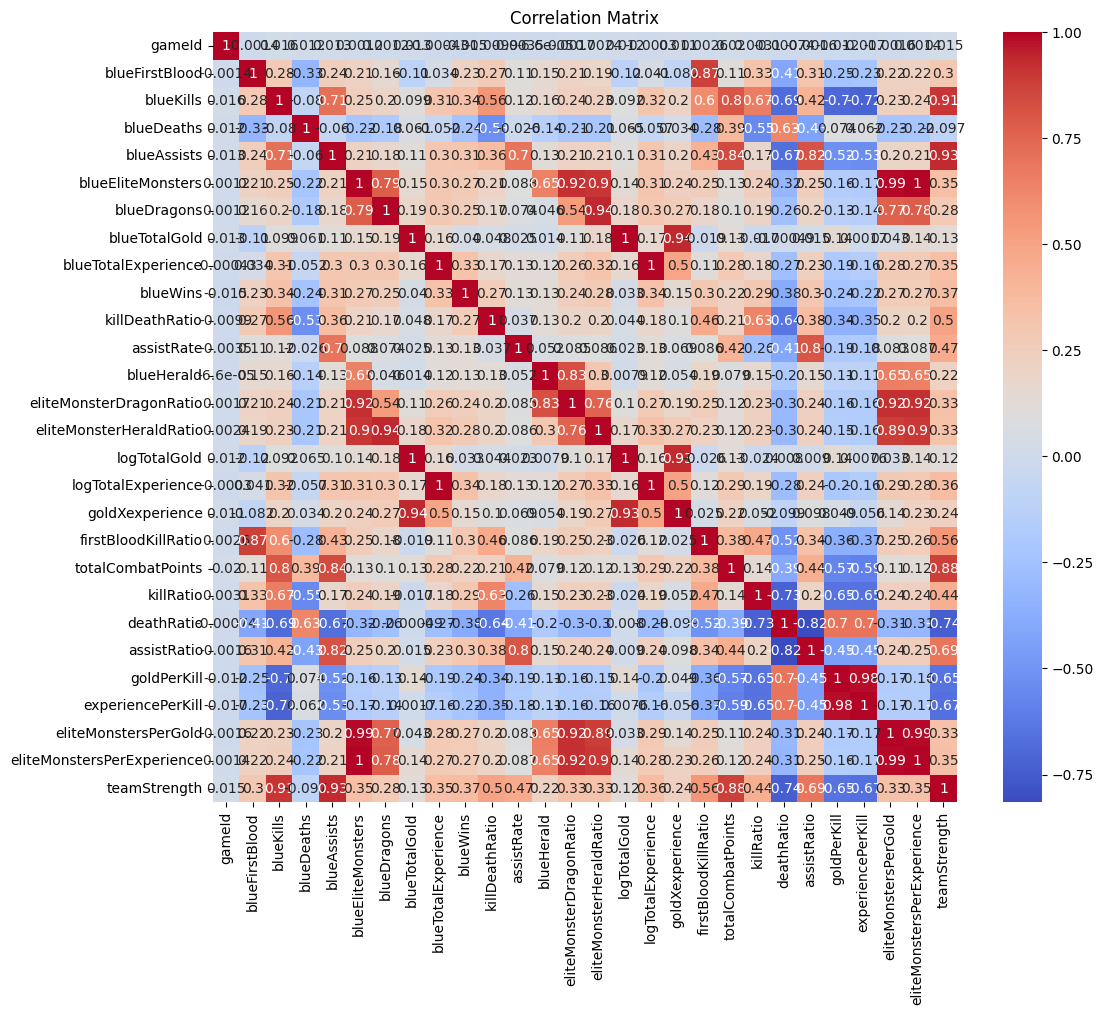

In [12]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- LightGBM

[I 2024-01-18 13:28:26,132] A new study created in memory with name: no-name-52fc6902-d750-49aa-8948-4977356436b5


[I 2024-01-18 13:28:26,537] Trial 0 finished with value: 0.803125 and parameters: {'lambda_l1': 4.931580561046294e-07, 'lambda_l2': 2.0158223372966895e-07, 'num_leaves': 87, 'feature_fraction': 0.4354215191121676, 'bagging_fraction': 0.48558760327433137, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 0 with value: 0.803125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:26,651] Trial 1 finished with value: 0.805625 and parameters: {'lambda_l1': 1.3811651549267129e-05, 'lambda_l2': 1.9403713859085972e-08, 'num_leaves': 126, 'feature_fraction': 0.42079984845688795, 'bagging_fraction': 0.7900929651773639, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 1 with value: 0.805625.
[I 2024-01-18 13:28:26,749] Trial 2 finished with value: 0.801875 and parameters: {'lambda_l1': 4.5855838236677734e-07, 'lambda_l2': 0.011568948176717504, 'num_leaves': 54, 'feature_fraction': 0.5091155009828521, 'bagging_fraction': 0.817006476035135, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 1 with value: 0.805625.
[I 2024-01-18 13:28:26,801] Trial 3 finished with value: 0.798125 and parameters: {'lambda_l1': 0.0014894434559483993, 'lambda_l2': 0.00015634597947672532, 'num_leaves': 176, 'feature_fraction': 0.9290074966333083, 'bagging_fraction': 0.6214645340072011, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 1 with valu

Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:26,861] Trial 4 finished with value: 0.80125 and parameters: {'lambda_l1': 0.0011494831532148236, 'lambda_l2': 1.121770773793419e-06, 'num_leaves': 62, 'feature_fraction': 0.40639191619475584, 'bagging_fraction': 0.6983021853833675, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 1 with value: 0.805625.
[I 2024-01-18 13:28:26,924] Trial 5 finished with value: 0.795625 and parameters: {'lambda_l1': 0.02675374010105695, 'lambda_l2': 1.0125915456594716e-05, 'num_leaves': 46, 'feature_fraction': 0.7218434966320229, 'bagging_fraction': 0.7922048912239337, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 1 with value: 0.805625.
[I 2024-01-18 13:28:27,016] Trial 6 finished with value: 0.79625 and parameters: {'lambda_l1': 3.400737900553615e-07, 'lambda_l2': 0.06389361392201574, 'num_leaves': 91, 'feature_fraction': 0.4136826864344447, 'bagging_fraction': 0.4715509591623014, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 1 with value: 0.8056

Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.204375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.21375


[I 2024-01-18 13:28:27,202] Trial 8 finished with value: 0.788125 and parameters: {'lambda_l1': 0.0017416729685100021, 'lambda_l2': 9.124386977928885e-07, 'num_leaves': 243, 'feature_fraction': 0.4918431060130686, 'bagging_fraction': 0.43244985929417906, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 1 with value: 0.805625.
[I 2024-01-18 13:28:27,239] Trial 9 finished with value: 0.79375 and parameters: {'lambda_l1': 0.009796713350173025, 'lambda_l2': 0.00017954459562646272, 'num_leaves': 16, 'feature_fraction': 0.9482433521194965, 'bagging_fraction': 0.8932643517445535, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 1 with value: 0.805625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.211875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.20625


[I 2024-01-18 13:28:27,391] Trial 10 finished with value: 0.808125 and parameters: {'lambda_l1': 1.4252421393862114e-05, 'lambda_l2': 7.317703189790055e-08, 'num_leaves': 145, 'feature_fraction': 0.5730837117995585, 'bagging_fraction': 0.973641497094828, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 10 with value: 0.808125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.191875


[I 2024-01-18 13:28:27,603] Trial 11 finished with value: 0.810625 and parameters: {'lambda_l1': 1.892189825580717e-05, 'lambda_l2': 1.125089083849076e-08, 'num_leaves': 147, 'feature_fraction': 0.5578299194094912, 'bagging_fraction': 0.9953685540934853, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:27,737] Trial 12 finished with value: 0.804375 and parameters: {'lambda_l1': 2.1786981023778933e-05, 'lambda_l2': 1.364120467379525e-08, 'num_leaves': 169, 'feature_fraction': 0.5854736308988615, 'bagging_fraction': 0.9882747371124372, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:27,882] Trial 13 finished with value: 0.810625 and parameters: {'lambda_l1': 2.156938866684179e-08, 'lambda_l2': 1.0172577672310955e-08, 'num_leaves': 135, 'feature_fraction': 0.6219928872216427, 'bagging_fraction': 0.9376976158060304, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 11 with value: 0.810625.


Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.189375


[I 2024-01-18 13:28:28,065] Trial 14 finished with value: 0.8025 and parameters: {'lambda_l1': 1.7133577945848238e-08, 'lambda_l2': 1.705234084875029e-08, 'num_leaves': 216, 'feature_fraction': 0.6636866576458771, 'bagging_fraction': 0.9166818935316883, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:28,267] Trial 15 finished with value: 0.80625 and parameters: {'lambda_l1': 2.3873879550176487e-08, 'lambda_l2': 4.089910911799598e-06, 'num_leaves': 128, 'feature_fraction': 0.7203712915499767, 'bagging_fraction': 0.9826740709607287, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:28,427] Trial 16 finished with value: 0.800625 and parameters: {'lambda_l1': 1.551360432953892e-08, 'lambda_l2': 1.7042144363178963e-07, 'num_leaves': 204, 'feature_fraction': 0.6556402197225586, 'bagging_fraction': 0.894243317776325, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 11 with value: 0.810625.


Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.199375


[I 2024-01-18 13:28:28,622] Trial 17 finished with value: 0.803125 and parameters: {'lambda_l1': 9.629687578232276e-05, 'lambda_l2': 1.099974206436982e-08, 'num_leaves': 104, 'feature_fraction': 0.7855837870581022, 'bagging_fraction': 0.9173035566882665, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:28,800] Trial 18 finished with value: 0.80875 and parameters: {'lambda_l1': 1.6559020125195484e-06, 'lambda_l2': 2.5005175561843053e-05, 'num_leaves': 157, 'feature_fraction': 0.6008417254173068, 'bagging_fraction': 0.9932250364911218, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:28,925] Trial 19 finished with value: 0.808125 and parameters: {'lambda_l1': 8.761963648424154e-08, 'lambda_l2': 7.273975826204382e-07, 'num_leaves': 209, 'feature_fraction': 0.5100495757829451, 'bagging_fraction': 0.86160631045691, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 11 with value: 0.810625.


Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.191875


[I 2024-01-18 13:28:29,104] Trial 20 finished with value: 0.80125 and parameters: {'lambda_l1': 2.444452452418541e-06, 'lambda_l2': 0.0034893244451899433, 'num_leaves': 111, 'feature_fraction': 0.7899864658011196, 'bagging_fraction': 0.8425507444665759, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:29,216] Trial 21 finished with value: 0.803125 and parameters: {'lambda_l1': 2.0334080237473823e-06, 'lambda_l2': 3.739572970887138e-05, 'num_leaves': 153, 'feature_fraction': 0.5947167116939851, 'bagging_fraction': 0.9855371016804025, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:29,359] Trial 22 finished with value: 0.8075 and parameters: {'lambda_l1': 1.213159394842265e-07, 'lambda_l2': 1.4789747218983252e-05, 'num_leaves': 144, 'feature_fraction': 0.6103946907940391, 'bagging_fraction': 0.9425131680164971, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 11 with value: 0.810625.


Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.1925


[I 2024-01-18 13:28:29,533] Trial 23 finished with value: 0.80875 and parameters: {'lambda_l1': 1.5123679110668596e-06, 'lambda_l2': 7.163749044102159e-08, 'num_leaves': 193, 'feature_fraction': 0.5535618192531844, 'bagging_fraction': 0.9476159959743151, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:29,665] Trial 24 finished with value: 0.80375 and parameters: {'lambda_l1': 1.0086396001449006e-08, 'lambda_l2': 3.3437308540329824e-06, 'num_leaves': 158, 'feature_fraction': 0.6389882510860414, 'bagging_fraction': 0.9402093853583906, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:29,788] Trial 25 finished with value: 0.805 and parameters: {'lambda_l1': 4.660278205875563e-06, 'lambda_l2': 0.0006894103283123839, 'num_leaves': 255, 'feature_fraction': 0.5487193548781676, 'bagging_fraction': 0.8694601760286319, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 11 with value: 0.810625.


Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:29,903] Trial 26 finished with value: 0.80375 and parameters: {'lambda_l1': 0.00010998972946040222, 'lambda_l2': 1.9614454178946874e-07, 'num_leaves': 126, 'feature_fraction': 0.6449008420358133, 'bagging_fraction': 0.9874402592048775, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 11 with value: 0.810625.


Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.191875


[I 2024-01-18 13:28:30,104] Trial 27 finished with value: 0.808125 and parameters: {'lambda_l1': 5.7956544573525566e-08, 'lambda_l2': 6.857159044500661e-05, 'num_leaves': 189, 'feature_fraction': 0.5400495779034606, 'bagging_fraction': 0.9446609534326585, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:30,273] Trial 28 finished with value: 0.803125 and parameters: {'lambda_l1': 2.1506608002932155e-07, 'lambda_l2': 8.893228791072726, 'num_leaves': 82, 'feature_fraction': 0.4671081614762977, 'bagging_fraction': 0.888428390901054, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:30,379] Trial 29 finished with value: 0.80125 and parameters: {'lambda_l1': 8.521671651688479e-07, 'lambda_l2': 5.919113290421804e-08, 'num_leaves': 228, 'feature_fraction': 0.6080044698697556, 'bagging_fraction': 0.9996656670592574, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 11 with value

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.19875


[I 2024-01-18 13:28:30,483] Trial 30 finished with value: 0.805 and parameters: {'lambda_l1': 5.313090804089137e-07, 'lambda_l2': 3.930342548865762e-07, 'num_leaves': 103, 'feature_fraction': 0.4679048155715723, 'bagging_fraction': 0.9177787042883672, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.1975


[I 2024-01-18 13:28:30,626] Trial 31 finished with value: 0.8025 and parameters: {'lambda_l1': 1.183769486026491e-06, 'lambda_l2': 6.575434507703336e-08, 'num_leaves': 195, 'feature_fraction': 0.5559452005876975, 'bagging_fraction': 0.9522615073132575, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:30,770] Trial 32 finished with value: 0.803125 and parameters: {'lambda_l1': 1.1900211792056154e-05, 'lambda_l2': 4.861419676638402e-08, 'num_leaves': 163, 'feature_fraction': 0.527000090603387, 'bagging_fraction': 0.9551378497876735, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:30,911] Trial 33 finished with value: 0.805 and parameters: {'lambda_l1': 4.7587082674198584e-06, 'lambda_l2': 1.0419189743375111e-08, 'num_leaves': 143, 'feature_fraction': 0.5640177954334542, 'bagging_fraction': 0.8357009866933565, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 11 with val

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.195


[I 2024-01-18 13:28:31,048] Trial 34 finished with value: 0.81 and parameters: {'lambda_l1': 6.464670459393985e-08, 'lambda_l2': 2.038945007495848e-07, 'num_leaves': 174, 'feature_fraction': 0.46571421220150466, 'bagging_fraction': 0.8102683071708172, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:31,167] Trial 35 finished with value: 0.79875 and parameters: {'lambda_l1': 5.587673943563194e-08, 'lambda_l2': 2.755101731874455e-07, 'num_leaves': 138, 'feature_fraction': 0.4614783076186014, 'bagging_fraction': 0.7492996082177894, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.20125


[I 2024-01-18 13:28:31,296] Trial 36 finished with value: 0.805 and parameters: {'lambda_l1': 2.7227435528031874e-07, 'lambda_l2': 3.183529904724051e-08, 'num_leaves': 116, 'feature_fraction': 0.5121466009861616, 'bagging_fraction': 0.8661083005512462, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:31,470] Trial 37 finished with value: 0.79875 and parameters: {'lambda_l1': 1.424956324048139e-07, 'lambda_l2': 2.564089508436607e-06, 'num_leaves': 177, 'feature_fraction': 0.4324013711497584, 'bagging_fraction': 0.8138983224940075, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:31,629] Trial 38 finished with value: 0.798125 and parameters: {'lambda_l1': 5.088869949736534e-07, 'lambda_l2': 2.011020588638756e-07, 'num_leaves': 72, 'feature_fraction': 0.4996280549981218, 'bagging_fraction': 0.7438808542592591, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 11 with value: 0.810625.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.201875


[I 2024-01-18 13:28:31,781] Trial 39 finished with value: 0.81 and parameters: {'lambda_l1': 4.169206181225197e-08, 'lambda_l2': 1.3823528991682047e-06, 'num_leaves': 181, 'feature_fraction': 0.42887785298347, 'bagging_fraction': 0.9997896685999884, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:31,883] Trial 40 finished with value: 0.791875 and parameters: {'lambda_l1': 4.267128261202494e-08, 'lambda_l2': 9.781352114710765e-07, 'num_leaves': 224, 'feature_fraction': 0.4045321482902553, 'bagging_fraction': 0.6547888188892483, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.208125


[I 2024-01-18 13:28:32,006] Trial 41 finished with value: 0.806875 and parameters: {'lambda_l1': 3.6076413349394064e-08, 'lambda_l2': 2.7045964831116184e-08, 'num_leaves': 183, 'feature_fraction': 0.4528582134191089, 'bagging_fraction': 0.9962006150901993, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:32,107] Trial 42 finished with value: 0.80125 and parameters: {'lambda_l1': 1.2558342651601203e-07, 'lambda_l2': 4.889190616120443e-07, 'num_leaves': 166, 'feature_fraction': 0.4893779183489902, 'bagging_fraction': 0.9224826423096609, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.19875


[I 2024-01-18 13:28:32,218] Trial 43 finished with value: 0.79875 and parameters: {'lambda_l1': 1.180934749939848e-08, 'lambda_l2': 1.3930166660798746e-07, 'num_leaves': 155, 'feature_fraction': 0.4398062885421768, 'bagging_fraction': 0.9666148664716918, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:32,352] Trial 44 finished with value: 0.803125 and parameters: {'lambda_l1': 3.6481797698622547e-07, 'lambda_l2': 2.095738435570952e-06, 'num_leaves': 135, 'feature_fraction': 0.41898212171533894, 'bagging_fraction': 0.965579436337238, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.196875


[I 2024-01-18 13:28:32,502] Trial 45 finished with value: 0.796875 and parameters: {'lambda_l1': 5.6874472435433336e-08, 'lambda_l2': 2.852045487858314e-08, 'num_leaves': 169, 'feature_fraction': 0.5275444743918873, 'bagging_fraction': 0.9984530231810932, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:32,621] Trial 46 finished with value: 0.8025 and parameters: {'lambda_l1': 1.9899592966170349e-07, 'lambda_l2': 1.3113196290415565e-06, 'num_leaves': 118, 'feature_fraction': 0.4731652137758503, 'bagging_fraction': 0.9047128179402442, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.203125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.1975


[I 2024-01-18 13:28:32,782] Trial 47 finished with value: 0.8075 and parameters: {'lambda_l1': 2.647223473462313e-08, 'lambda_l2': 1.5073961520534267e-05, 'num_leaves': 151, 'feature_fraction': 0.4909487323107061, 'bagging_fraction': 0.9275115407804222, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:32,885] Trial 48 finished with value: 0.798125 and parameters: {'lambda_l1': 5.20271829638149e-07, 'lambda_l2': 5.121985562677165e-06, 'num_leaves': 11, 'feature_fraction': 0.5825188982177075, 'bagging_fraction': 0.9636128635359633, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_error: 0.201875


[I 2024-01-18 13:28:33,063] Trial 49 finished with value: 0.801875 and parameters: {'lambda_l1': 3.1800338164252065e-08, 'lambda_l2': 1.0113864009288185e-08, 'num_leaves': 201, 'feature_fraction': 0.525822051655959, 'bagging_fraction': 0.8785379985052925, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_error: 0.198125


[I 2024-01-18 13:28:33,253] Trial 50 finished with value: 0.81 and parameters: {'lambda_l1': 8.963865804533567e-08, 'lambda_l2': 9.659239125912343e-08, 'num_leaves': 180, 'feature_fraction': 0.43733252774886755, 'bagging_fraction': 0.9706406033929067, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.195625


[I 2024-01-18 13:28:33,384] Trial 51 finished with value: 0.804375 and parameters: {'lambda_l1': 7.728221403244476e-08, 'lambda_l2': 8.193671791910148e-08, 'num_leaves': 176, 'feature_fraction': 0.4284231937120921, 'bagging_fraction': 0.9691467519532571, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:33,485] Trial 52 finished with value: 0.804375 and parameters: {'lambda_l1': 2.020960816685019e-08, 'lambda_l2': 2.4993783891029796e-08, 'num_leaves': 40, 'feature_fraction': 0.4045111059194131, 'bagging_fraction': 0.9017365405328311, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:33,629] Trial 53 finished with value: 0.80625 and parameters: {'lambda_l1': 2.494270606652862e-07, 'lambda_l2': 3.645647793640272e-07, 'num_leaves': 172, 'feature_fraction': 0.4358564838277198, 'bagging_fraction': 0.9274774910490258, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 11 with v

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.19375


[I 2024-01-18 13:28:33,825] Trial 54 finished with value: 0.805625 and parameters: {'lambda_l1': 1.0750412608555706e-08, 'lambda_l2': 1.0892307923968826e-07, 'num_leaves': 186, 'feature_fraction': 0.4536932732328604, 'bagging_fraction': 0.9760931293410876, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 11 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:34,013] Trial 55 finished with value: 0.80625 and parameters: {'lambda_l1': 8.701910396678177e-07, 'lambda_l2': 8.057945404888102e-07, 'num_leaves': 215, 'feature_fraction': 0.5772624019142559, 'bagging_fraction': 0.9985581573149626, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 11 with value: 0.810625.
[I 2024-01-18 13:28:34,139] Trial 56 finished with value: 0.81125 and parameters: {'lambda_l1': 1.0961573101261905e-07, 'lambda_l2': 2.3298235093132672e-08, 'num_leaves': 131, 'feature_fraction': 0.4831800206469776, 'bagging_fraction': 0.8999294213601426, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 56 with value: 0.81125.


Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.18875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:34,301] Trial 57 finished with value: 0.81 and parameters: {'lambda_l1': 1.2418276024046918e-07, 'lambda_l2': 3.106178109371505e-08, 'num_leaves': 128, 'feature_fraction': 0.4856403259356414, 'bagging_fraction': 0.897312773080451, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 56 with value: 0.81125.
[I 2024-01-18 13:28:34,466] Trial 58 finished with value: 0.805625 and parameters: {'lambda_l1': 7.506119773361181e-08, 'lambda_l2': 1.8257155676896635e-08, 'num_leaves': 105, 'feature_fraction': 0.446280574855152, 'bagging_fraction': 0.937266367572392, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 56 with value: 0.81125.


Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.194375


[I 2024-01-18 13:28:34,699] Trial 59 finished with value: 0.790625 and parameters: {'lambda_l1': 2.279995327652989e-08, 'lambda_l2': 1.6444897361969968e-07, 'num_leaves': 146, 'feature_fraction': 0.47975545948105164, 'bagging_fraction': 0.8819237669484503, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 56 with value: 0.81125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.209375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:34,878] Trial 60 finished with value: 0.805625 and parameters: {'lambda_l1': 2.8545609491129744e-08, 'lambda_l2': 9.74102845317487e-08, 'num_leaves': 96, 'feature_fraction': 0.4191815516522248, 'bagging_fraction': 0.8469093670836823, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 56 with value: 0.81125.
[I 2024-01-18 13:28:35,014] Trial 61 finished with value: 0.8125 and parameters: {'lambda_l1': 1.3687243461378762e-07, 'lambda_l2': 4.000502690817725e-08, 'num_leaves': 132, 'feature_fraction': 0.5083858599415259, 'bagging_fraction': 0.9095970552731608, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 61 with value: 0.8125.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1875


[I 2024-01-18 13:28:35,174] Trial 62 finished with value: 0.80625 and parameters: {'lambda_l1': 1.1095218395744815e-07, 'lambda_l2': 1.5009029074907433e-08, 'num_leaves': 134, 'feature_fraction': 0.5046027138194679, 'bagging_fraction': 0.9074854176338943, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:35,329] Trial 63 finished with value: 0.810625 and parameters: {'lambda_l1': 2.5849813800673885e-07, 'lambda_l2': 4.95692377358122e-08, 'num_leaves': 163, 'feature_fraction': 0.5136458535297634, 'bagging_fraction': 0.9461866379549666, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:35,468] Trial 64 finished with value: 0.80625 and parameters: {'lambda_l1': 4.102209102910772e-07, 'lambda_l2': 3.971827078887787e-08, 'num_leaves': 116, 'feature_fraction': 0.5468282986270252, 'bagging_fraction': 0.9321685756259009, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 61 with value: 0.8125.


Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.19375


[I 2024-01-18 13:28:35,620] Trial 65 finished with value: 0.804375 and parameters: {'lambda_l1': 2.3203419380540338e-07, 'lambda_l2': 4.6951794759368124e-08, 'num_leaves': 162, 'feature_fraction': 0.5189523479704333, 'bagging_fraction': 0.9468573575073526, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:35,762] Trial 66 finished with value: 0.805 and parameters: {'lambda_l1': 1.580634343935467e-08, 'lambda_l2': 1.6749284125306935e-08, 'num_leaves': 149, 'feature_fraction': 0.5348256991733685, 'bagging_fraction': 0.8559330526075168, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:35,884] Trial 67 finished with value: 0.8 and parameters: {'lambda_l1': 4.9307780738273305e-08, 'lambda_l2': 2.7393037844608796e-07, 'num_leaves': 139, 'feature_fraction': 0.49803171690283626, 'bagging_fraction': 0.8876433514896811, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 61 with value: 0.8125.


Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:36,075] Trial 68 finished with value: 0.810625 and parameters: {'lambda_l1': 8.943925070927711e-07, 'lambda_l2': 1.076412408293734e-08, 'num_leaves': 131, 'feature_fraction': 0.4729642165668749, 'bagging_fraction': 0.9123623140568303, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:36,276] Trial 69 finished with value: 0.804375 and parameters: {'lambda_l1': 8.540051334069437e-07, 'lambda_l2': 1.2548933504485798e-08, 'num_leaves': 127, 'feature_fraction': 0.5633444958264642, 'bagging_fraction': 0.871328478236909, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 61 with value: 0.8125.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.195625


[I 2024-01-18 13:28:36,431] Trial 70 finished with value: 0.806875 and parameters: {'lambda_l1': 5.42843034935329e-06, 'lambda_l2': 5.035422069374901e-08, 'num_leaves': 119, 'feature_fraction': 0.5094931632402739, 'bagging_fraction': 0.911563338637992, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:36,573] Trial 71 finished with value: 0.8125 and parameters: {'lambda_l1': 2.4332058096556235e-06, 'lambda_l2': 1.0163135290637573e-08, 'num_leaves': 155, 'feature_fraction': 0.46375245015510247, 'bagging_fraction': 0.9488119748967652, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:36,756] Trial 72 finished with value: 0.8125 and parameters: {'lambda_l1': 2.5317509103126467e-06, 'lambda_l2': 1.0159138541372824e-08, 'num_leaves': 133, 'feature_fraction': 0.4616344667073167, 'bagging_fraction': 0.9513771279355752, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 61 with value: 0.8125.


Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.1875


[I 2024-01-18 13:28:36,897] Trial 73 finished with value: 0.809375 and parameters: {'lambda_l1': 1.6395857717439138e-06, 'lambda_l2': 2.6273243324706885e-08, 'num_leaves': 109, 'feature_fraction': 0.4791992342716208, 'bagging_fraction': 0.951866599745597, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.198125


[I 2024-01-18 13:28:37,018] Trial 74 finished with value: 0.801875 and parameters: {'lambda_l1': 3.6639338102879355e-06, 'lambda_l2': 1.7129804599753562e-08, 'num_leaves': 124, 'feature_fraction': 0.5404452613957115, 'bagging_fraction': 0.9266224687315722, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:37,161] Trial 75 finished with value: 0.801875 and parameters: {'lambda_l1': 2.2747303136555977e-06, 'lambda_l2': 1.1526929552477389e-08, 'num_leaves': 132, 'feature_fraction': 0.46161673192387476, 'bagging_fraction': 0.9798284656206232, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:37,282] Trial 76 finished with value: 0.8075 and parameters: {'lambda_l1': 9.146020080521242e-06, 'lambda_l2': 5.0866857835788915e-08, 'num_leaves': 142, 'feature_fraction': 0.5153899232334406, 'bagging_fraction': 0.9537355810861178, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 61 with 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1925


[I 2024-01-18 13:28:37,424] Trial 77 finished with value: 0.811875 and parameters: {'lambda_l1': 1.0843963712536453e-06, 'lambda_l2': 2.2013304750766767e-08, 'num_leaves': 92, 'feature_fraction': 0.49835783445308435, 'bagging_fraction': 0.9138114706428071, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.188125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:37,586] Trial 78 finished with value: 0.811875 and parameters: {'lambda_l1': 2.643861351065408e-06, 'lambda_l2': 2.4950693769476597e-08, 'num_leaves': 84, 'feature_fraction': 0.562115001393657, 'bagging_fraction': 0.9381749974853112, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 61 with value: 0.8125.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.188125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.195625


[I 2024-01-18 13:28:37,770] Trial 79 finished with value: 0.804375 and parameters: {'lambda_l1': 2.745653671505008e-05, 'lambda_l2': 2.1427750703455616e-08, 'num_leaves': 85, 'feature_fraction': 0.5656126618551954, 'bagging_fraction': 0.8908801623799386, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:37,950] Trial 80 finished with value: 0.8 and parameters: {'lambda_l1': 2.501101168916178e-06, 'lambda_l2': 1.0343308457185768e-07, 'num_leaves': 57, 'feature_fraction': 0.5959497136166519, 'bagging_fraction': 0.9348982334131959, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:38,083] Trial 81 finished with value: 0.80625 and parameters: {'lambda_l1': 1.2857940963921735e-06, 'lambda_l2': 3.9051342618742864e-08, 'num_leaves': 96, 'feature_fraction': 0.5473875299743236, 'bagging_fraction': 0.9569521999801897, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 61 with value: 0.

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.19375


[I 2024-01-18 13:28:38,203] Trial 82 finished with value: 0.8075 and parameters: {'lambda_l1': 3.978874544567539e-07, 'lambda_l2': 6.306306755060025e-08, 'num_leaves': 76, 'feature_fraction': 0.5007082254222186, 'bagging_fraction': 0.9824441629752352, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:38,334] Trial 83 finished with value: 0.80375 and parameters: {'lambda_l1': 6.028327564122529e-07, 'lambda_l2': 2.5482999449348636e-08, 'num_leaves': 45, 'feature_fraction': 0.6147497890947955, 'bagging_fraction': 0.9456901503025521, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19625


[I 2024-01-18 13:28:38,498] Trial 84 finished with value: 0.804375 and parameters: {'lambda_l1': 1.768870196412206e-07, 'lambda_l2': 1.0212201609361706e-08, 'num_leaves': 157, 'feature_fraction': 0.5347170322623029, 'bagging_fraction': 0.9132786832752997, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:38,628] Trial 85 finished with value: 0.80875 and parameters: {'lambda_l1': 2.0807931226759427e-05, 'lambda_l2': 3.7858065977004023e-08, 'num_leaves': 150, 'feature_fraction': 0.5187967156915273, 'bagging_fraction': 0.9776055085743233, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.19125


[I 2024-01-18 13:28:38,761] Trial 86 finished with value: 0.8 and parameters: {'lambda_l1': 3.671341950885292e-06, 'lambda_l2': 1.9753476299534327e-08, 'num_leaves': 65, 'feature_fraction': 0.492276010235977, 'bagging_fraction': 0.9357642441241689, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:38,881] Trial 87 finished with value: 0.799375 and parameters: {'lambda_l1': 6.925479230225839e-06, 'lambda_l2': 6.796178808202365e-08, 'num_leaves': 33, 'feature_fraction': 0.5696750598672984, 'bagging_fraction': 0.92090136343749, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.200625


[I 2024-01-18 13:28:39,062] Trial 88 finished with value: 0.805 and parameters: {'lambda_l1': 1.7129909607101581e-06, 'lambda_l2': 1.4315505569982323e-07, 'num_leaves': 90, 'feature_fraction': 0.45159329810669513, 'bagging_fraction': 0.9628288654401501, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:28:39,209] Trial 89 finished with value: 0.81 and parameters: {'lambda_l1': 3.451084810222818e-07, 'lambda_l2': 1.671225486147807e-08, 'num_leaves': 161, 'feature_fraction': 0.5517357360122397, 'bagging_fraction': 0.8946520331687783, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:39,366] Trial 90 finished with value: 0.80375 and parameters: {'lambda_l1': 5.963361271229161e-07, 'lambda_l2': 3.1021169365136225e-08, 'num_leaves': 121, 'feature_fraction': 0.5277445071476341, 'bagging_fraction': 0.8637379036944661, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 61 with value: 0.8125.


Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.19625


[I 2024-01-18 13:28:39,528] Trial 91 finished with value: 0.804375 and parameters: {'lambda_l1': 2.7779957731568118e-06, 'lambda_l2': 1.0210047262180519e-08, 'num_leaves': 138, 'feature_fraction': 0.47244140960815445, 'bagging_fraction': 0.9105833632528594, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:39,631] Trial 92 finished with value: 0.7975 and parameters: {'lambda_l1': 9.25951713501033e-07, 'lambda_l2': 1.7162344228075154e-08, 'num_leaves': 110, 'feature_fraction': 0.4833046974436641, 'bagging_fraction': 0.9422641787256028, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.2025


[I 2024-01-18 13:28:39,760] Trial 93 finished with value: 0.8025 and parameters: {'lambda_l1': 1.1542977003636973e-06, 'lambda_l2': 5.5087075144529334e-08, 'num_leaves': 146, 'feature_fraction': 0.502861966720706, 'bagging_fraction': 0.91911881917947, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:39,875] Trial 94 finished with value: 0.80875 and parameters: {'lambda_l1': 1.8387971986000098e-07, 'lambda_l2': 2.2915516417254484e-08, 'num_leaves': 100, 'feature_fraction': 0.46370136433711445, 'bagging_fraction': 0.9619004102050874, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.19125


[I 2024-01-18 13:28:40,006] Trial 95 finished with value: 0.79875 and parameters: {'lambda_l1': 7.515743079750338e-06, 'lambda_l2': 7.726958036640295e-08, 'num_leaves': 130, 'feature_fraction': 0.4763866758249603, 'bagging_fraction': 0.8817101637765221, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 61 with value: 0.8125.
[I 2024-01-18 13:28:40,150] Trial 96 finished with value: 0.806875 and parameters: {'lambda_l1': 2.853675033346382e-07, 'lambda_l2': 1.0472738694612897e-08, 'num_leaves': 156, 'feature_fraction': 0.5102098650557318, 'bagging_fraction': 0.9839156109969134, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 61 with value: 0.8125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.193125


[I 2024-01-18 13:28:40,281] Trial 97 finished with value: 0.81375 and parameters: {'lambda_l1': 3.6351935897385643e-06, 'lambda_l2': 3.378496028393687e-08, 'num_leaves': 79, 'feature_fraction': 0.4521548996929963, 'bagging_fraction': 0.932853773624739, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 97 with value: 0.81375.
[I 2024-01-18 13:28:40,413] Trial 98 finished with value: 0.805 and parameters: {'lambda_l1': 5.303375208523259e-06, 'lambda_l2': 3.895738714055293e-08, 'num_leaves': 71, 'feature_fraction': 0.4471307703076764, 'bagging_fraction': 0.9319611430363791, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 97 with value: 0.81375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.18625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.195


[I 2024-01-18 13:28:40,554] Trial 99 finished with value: 0.81 and parameters: {'lambda_l1': 1.488185219687349e-05, 'lambda_l2': 1.2788228638303207e-07, 'num_leaves': 80, 'feature_fraction': 0.5851739699907362, 'bagging_fraction': 0.9699818493113388, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 97 with value: 0.81375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.19
[1 1 0 ... 1 1 0]


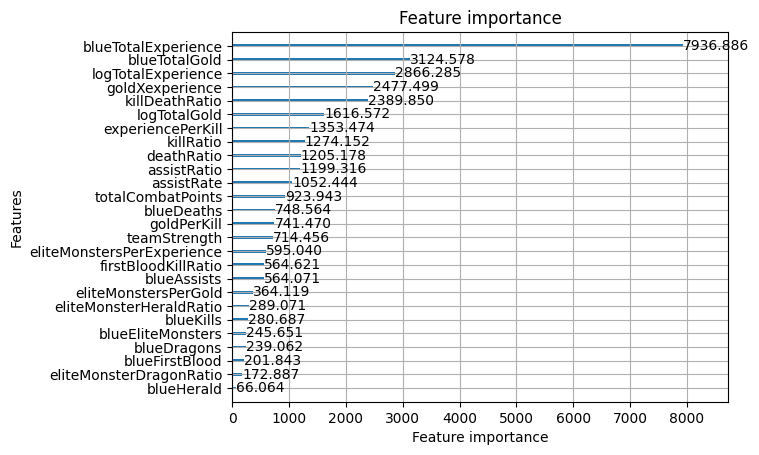

assistRatio: 613
killRatio: 608
killDeathRatio: 593
goldXexperience: 527
deathRatio: 524
assistRate: 516
experiencePerKill: 514
totalCombatPoints: 424
goldPerKill: 394
blueDeaths: 322
blueTotalGold: 304
teamStrength: 303
blueAssists: 260
blueTotalExperience: 246
eliteMonstersPerExperience: 208
firstBloodKillRatio: 190
logTotalGold: 183
eliteMonstersPerGold: 179
logTotalExperience: 146
blueKills: 128
blueDragons: 89
blueFirstBlood: 76
blueEliteMonsters: 72
eliteMonsterDragonRatio: 64
eliteMonsterHeraldRatio: 51
blueHerald: 32


In [7]:


# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

# Optunaでのハイパーパラメータチューニング
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=True)
    model = lgb.train(param, lgb_train, num_boost_round=1000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X, y)
model = lgb.train(best_params, lgb_train, num_boost_round=study.best_trial.number)

# テストデータに対する予測
y_test_pred = model.predict(test_drop_gameId)
y_test_pred_int = (y_test_pred > 0.5).astype(int)

# 予測結果の表示
print(y_test_pred_int)


# 特徴量の重要度をプロット
lgb.plot_importance(model, importance_type='gain', max_num_features=30)
plt.show()

# 特徴量の重要度を取得
importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

# 特徴量とその重要度をペアにして表示
feature_importances = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
for name, imp in feature_importances:
    print(f"{name}: {imp}")


- testにy_test_pred結合

In [8]:
output = '../data/output/submit_cv_oputuna_add_feature_drop_gameId.csv'

In [9]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_int
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [10]:
check = pd.read_csv(output)

In [11]:
check

,9,1
0,15,1
1,18,0
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
